In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, figure, show, xlabel, ylabel, legend, subplot, semilogx, grid, loglog, title, clim
from sklearn import model_selection, tree
%matplotlib inline
import sklearn.linear_model as lm
from toolbox_02450 import rlr_validate, feature_selector_lr, bmplot
import random


/Users/nikolaj/Desktop/GIT/MLDM-Assignment-2/toolbox_02450/__init__.py:115: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if display is 'verbose':


In [2]:
#Dataload
glass_dataset = pd.read_csv('data/glass.csv', header = 0)

#Uncomment if validation set is wanted
# random.seed(1234)
# validation_idxs = random.sample(range(0,213),11)
# validation_dataset = glass_dataset.iloc[validation_idxs]
# glass_dataset = glass_dataset.drop(validation_idxs)


labels = list(glass_dataset.columns)
attributeNames = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba','Fe']

X = np.array(glass_dataset[attributeNames])
y = np.array(glass_dataset['RI'])
N, M = X.shape
print(glass_dataset.head())
# validation_dataset



   ID       RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0   1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1   2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2   3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3   4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4   5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1


Feature selection

In [3]:
#K-fold model for feature select
K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)



In [4]:
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

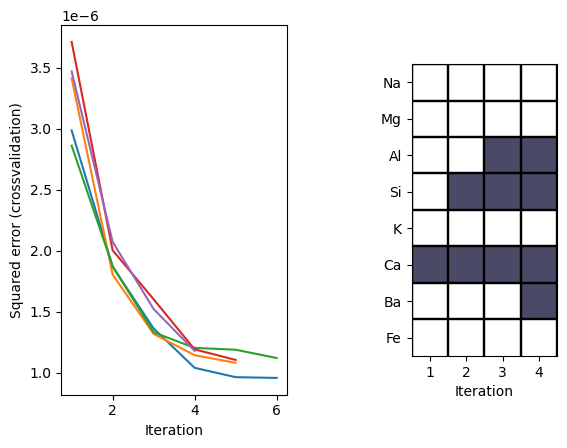

In [11]:
k=0
for train_index, test_index in CV.split(X):
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

In [7]:
# labels = attributeNames
# X = np.array(glass_dataset[labels])
# y = np.array(glass_dataset['RI'])
# attributeNames = labels
# glass_dataset[labels].head()

,Na,Mg,Al,Si,K,Ca,Ba
0,13.64,4.49,1.10,71.78,0.06,8.75,0.0
1,13.89,3.60,1.36,72.73,0.48,7.83,0.0
2,13.53,3.55,1.54,72.99,0.39,7.78,0.0
3,13.21,3.69,1.29,72.61,0.57,8.22,0.0
4,13.27,3.62,1.24,73.08,0.55,8.07,0.0


In [5]:
#Regularization
# print(X)
# print(Y)

standardized_X = (X-np.mean(X,0))/np.std(X,0)
# Kinda normal fordelt /TODO
# plt.hist(X[:,3],bins = 25)
# np.mean(X,0)
# np.std(X,0)
X = standardized_X
N, M = X.shape
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1



# Regularization

In [6]:
K = 10
CV = model_selection.KFold(K, shuffle=True)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))
lambdas = np.power(10.,range(-5,9))

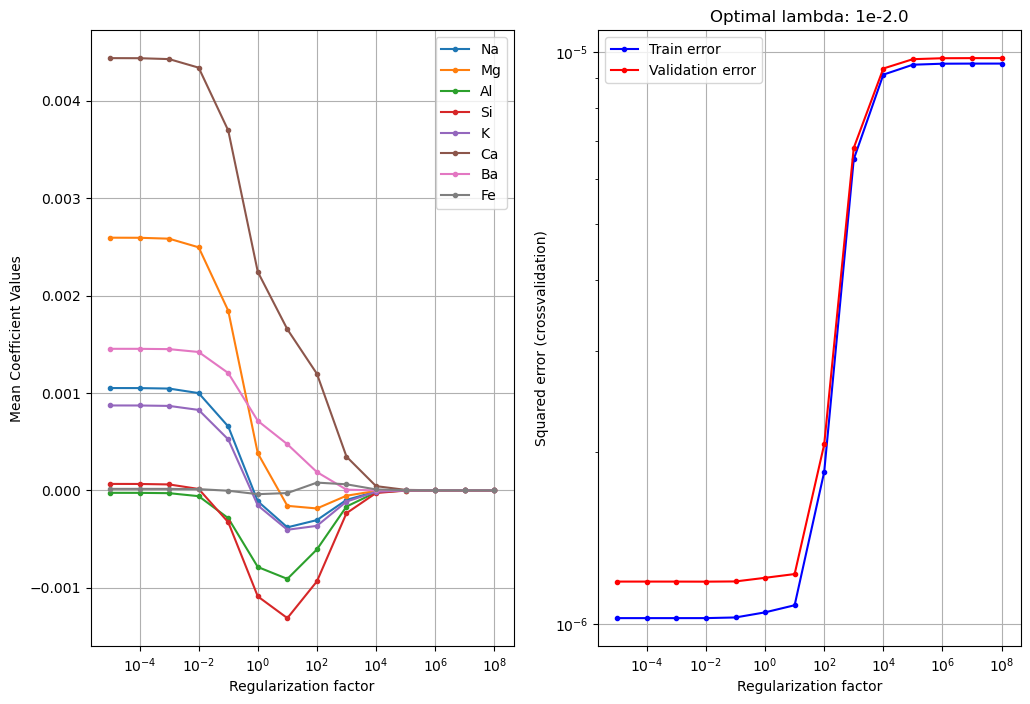

Linear regression without feature selection:
- Training error: 9.587821277846419e-07
- Test error:     1.1111773803267791e-06
- R^2 train:     0.8954914862778216
- R^2 test:     0.8730971655207975

Regularized linear regression:
- Training error: 9.595332295666037e-07
- Test error:     1.1100262871732726e-06
- R^2 train:     0.8954096151951093
- R^2 test:     0.873228626965672

Weights in last fold:
         Offset          1.5183
             Na           0.001
             Mg          0.0025
             Al         -0.0001
             Si             0.0
              K          0.0008
             Ca          0.0044
             Ba          0.0014
             Fe             0.0


In [14]:
k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],4)))


In [3]:
# ANN setup
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from toolbox_02450 import train_neural_net

loss_fn = torch.nn.MSELoss() 



In [4]:
attributeNames = ['Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba','Fe']

labels = attributeNames
X = np.array(glass_dataset[labels])
y = np.array(glass_dataset['RI'])
attributeNames = labels
glass_dataset[labels].head()
standardized_X = (X-np.mean(X,0))/np.std(X,0)
X = standardized_X
N, M = X.shape

In [14]:
from time import time


start_time = time()


outer_cross_validation  = 10
internal_cross_validation = 10
outer_Kfold = model_selection.KFold(outer_cross_validation, shuffle=True)
inner_Kfold = model_selection.KFold(internal_cross_validation, shuffle=True)


lambdas = np.power(10.,range(-5,9))

error_train_baseline = np.empty((outer_cross_validation,1))
error_test_baseline = np.empty((outer_cross_validation,1))

opt_lambda_array = np.empty((outer_cross_validation,1))
error_test_lin_mod = np.empty((outer_cross_validation,1))

hidden_units = [x for x in range(2,22,2)]
ANN_n_inner_error_array = np.empty((internal_cross_validation,len(hidden_units)))
ANN_outer_MSE_list = []
ANN_outer_hiddenH_list = []
tolerance_set = 1e-8

ite_start_time = time()
k = 0
outer_fold_counter = 0
for train_partition, test_partition in outer_Kfold.split(X,y):
    mid_time = time()
    outer_fold_counter +=1
    # print(train_partition, test_partition)
    X_partition_training = X[train_partition]
    y_partition_training = y[train_partition]
    X_partition_test = X[test_partition]
    y_partition_test = y[test_partition]

    
    
    f = 0
    ANN_inner_fold_error = []
    ANN_inner_fold_nets = []
    ANN_inner_fold_n_list = []
    ANN_n_inner_error_array = np.empty((internal_cross_validation,len(hidden_units)))
    
    for inner_fold_counter,(train_index, test_index) in enumerate(outer_Kfold.split(X_partition_training, y_partition_training)):
        # print(train_index, test_index)
        X_train = X_partition_training[train_index]
        y_train = y_partition_training[train_index]
        X_test = X_partition_training[test_index]
        y_test = y_partition_training[test_index]
        
        
        #Linear regression model
        X_for_lin_mod = np.concatenate((np.ones((X_train.shape[0],1)),X_train),1)
        X_for_lin_mod_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),1)
        # y_for_lin_mod = np.concatenate((np.ones((X_train.shape[0],1)),y_train),1)

        test_error = np.empty((internal_cross_validation,len(lambdas)))
        w = np.empty((M+1,internal_cross_validation,len(lambdas)))
        
        Xty = X_for_lin_mod.T @ y_train
        XtX = X_for_lin_mod.T @ X_for_lin_mod
        # print(Xty.shape)
        # print(XtX.shape)
        for l in range(0,len(lambdas)):
            # Compute parameters for current value of lambda and current CV fold
            # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
            lambdaI = lambdas[l] * np.eye(M+1)
            lambdaI[0,0] = 0 # remove bias regularization
            w[:,f,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
            # Evaluate training and test performance
            test_error[f,l] = np.power(y_test-X_for_lin_mod_test @ w[:,f,l].T,2).mean(axis=0)
        f += 1   
        
        # ANN
        X_train_tensor = torch.Tensor(X[train_index,:])
        y_train_tensor = torch.Tensor(y[train_index]).unsqueeze(1)
        X_test_tensor = torch.Tensor(X[test_index,:])
        y_test_tensor = torch.Tensor(y[test_index]).unsqueeze(1)
        
        # for n_idx, n in enumerate(hidden_units):
        #     ite_prev_time = ite_start_time
        #     ite_start_time = time()
            
        #     print(f'Currently on outerfold: {outer_fold_counter}, innerfold: {inner_fold_counter+1}, n_idx = {n_idx + 1}, iteration time = {ite_start_time-ite_prev_time}',end='\r')
            
        #     n_hidden_units = n
        #     inner_model = lambda: torch.nn.Sequential(
        #                 torch.nn.Linear(M, n_hidden_units), # Input equal to amount of attributes in dataset
        #                 torch.nn.ReLU(),   # 1st transfer function,
        #                 torch.nn.Linear(n_hidden_units,n_hidden_units ), 
        #                 # no final tranfer function, i.e. "linear output"
        #                 torch.nn.ReLU(),
        #                 torch.nn.Linear(n_hidden_units, 1 ) #Output is 1 continous variable equal to RI
        #                 )    
        #     net, final_loss, learning_curve = train_neural_net(inner_model,
        #                                                loss_fn,
        #                                                X=X_train_tensor,
        #                                                y=y_train_tensor,
        #                                                n_replicates=1,
        #                                                tolerance= tolerance_set)
        #         # Determine errors and errors
        #     # Determine estimated class labels for test set
        #     y_test_est_inner = net(X_test_tensor)
        #     se = (y_test_est_inner.float()-y_test_tensor.float())**2 # squared error
        #     mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
        #     ANN_n_inner_error_array[inner_fold_counter,n_idx] = mse
        
    ########################  
    #Baseline
    error_train_baseline[k] = np.square(y_partition_training-y_partition_training.mean()).sum(axis=0)/y_partition_training.shape[0]
    error_test_baseline[k] = np.square(y_partition_test-y_partition_test.mean()).sum(axis=0)/y_partition_test.shape[0]
    
    
    ######################
    # ANN Outer
    mean_error_of_inner_h = np.mean(ANN_n_inner_error_array,axis = 0)
    best_h = hidden_units[np.argmin(mean_error_of_inner_h)]
    ANN_outer_hiddenH_list.append(best_h)
    
    X_train_tensor = torch.Tensor(X_partition_training)
    y_train_tensor = torch.Tensor(y_partition_training).unsqueeze(1)
    X_test_tensor = torch.Tensor(X_partition_test)
    y_test_tensor = torch.Tensor(y_partition_test).unsqueeze(1)

    
        
    n_hidden_units = 10
    outer_model = lambda: torch.nn.Sequential(
                torch.nn.Linear(8, n_hidden_units), # Input equal to amount of attributes in dataset
                torch.nn.ReLU(),   # 1st transfer function,
                torch.nn.Linear(n_hidden_units, 1 ) #Output is 1 continous variable equal to RI
                )    
    
    net, final_loss, learning_curve = train_neural_net(outer_model,
                                                loss_fn,
                                                X=X_train_tensor,
                                                y=y_train_tensor,
                                                n_replicates=1,
                                                tolerance= tolerance_set)
        
    y_test_est_outer = net(X_test_tensor)
    se = (y_test_est_outer.float()-y_test_tensor.float())**2 # squared error
    print(y_test_est_outer)
    print(y_test_tensor)
    mse = (sum(se).type(torch.float)/len(y_test_est_outer)).data.numpy() #mean
    
    ANN_outer_MSE_list.append(mse)
    
    
    #################
    #RLR Outer
    opt_lambda_array[k] = lambdas[np.argmin(np.mean(test_error,axis=0))]
    
    
    X_partiton_for_lin_mod_test = np.concatenate((np.ones((X_partition_test.shape[0],1)),X_partition_test),1)
    
    lambdaI = opt_lambda_array[k] * np.eye(M+1)
    lambdaI[0,0] = 0
    Xty = X_for_lin_mod.T @ y_train
    XtX = X_for_lin_mod.T @ X_for_lin_mod
    w_rlr = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    error_test_lin_mod[k] = np.square(y_partition_test-X_partiton_for_lin_mod_test @ w_rlr).sum(axis=0)/y_partition_test.shape[0]





    # end_time = time()
    # print(f'Foldtime = {mid_time-end_time}, Runtime = {start_time-end_time}')
    #Enumerator for array indexies
    k += 1
    
error_for_pd = {'error_baseline':list(error_test_baseline),'error_lin_mod': list(error_test_lin_mod), 'error_ANN': list(ANN_outer_MSE_list)}
# print(error_test_baseline)
# print(error_test_lin_mod)
error_for_pd
# pd.DataFrame.from_dict(error_for_pd)
        
     

tensor([[1.5176],
        [1.5176],
        [1.5161],
        [1.5166],
        [1.5172],
        [1.5175],
        [1.5255],
        [1.5179],
        [1.5118],
        [1.5237],
        [1.5170],
        [1.5184],
        [1.5157],
        [1.5407],
        [1.5149],
        [1.5260],
        [1.5209],
        [1.5017],
        [1.5070],
        [1.5268],
        [1.5174],
        [1.2628]], grad_fn=<AddmmBackward0>)
tensor([[1.5177],
        [1.5192],
        [1.5175],
        [1.5176],
        [1.5175],
        [1.5179],
        [1.5191],
        [1.5180],
        [1.5122],
        [1.5157],
        [1.5159],
        [1.5185],
        [1.5169],
        [1.5202],
        [1.5167],
        [1.5184],
        [1.5213],
        [1.5167],
        [1.5132],
        [1.5191],
        [1.5160],
        [1.5165]])
tensor([[1.5061],
        [1.5121],
        [1.5120],
        [1.5257],
        [1.5222],
        [1.5223],
        [1.5244],
        [1.5223],
        [1.5198],
        [1.5152],


{'error_baseline': [array([4.01416942e-06]),
  array([7.92031488e-06]),
  array([8.22707707e-06]),
  array([8.12922169e-06]),
  array([4.29730794e-06]),
  array([4.29124127e-06]),
  array([9.05580862e-06]),
  array([4.09970113e-06]),
  array([1.10757134e-05]),
  array([2.38093442e-05])],
 'error_lin_mod': [array([3.86845659e-06]),
  array([5.06303569e-06]),
  array([6.22331182e-06]),
  array([6.84792188e-06]),
  array([3.90051451e-06]),
  array([3.10822281e-06]),
  array([6.23879578e-06]),
  array([2.98122617e-06]),
  array([9.11960097e-06]),
  array([2.00989585e-05])],
 'error_ANN': [array([0.00296811], dtype=float32),
  array([9.351341e-05], dtype=float32),
  array([0.01390885], dtype=float32),
  array([0.00271692], dtype=float32),
  array([0.00048324], dtype=float32),
  array([0.00571362], dtype=float32),
  array([0.00593727], dtype=float32),
  array([7.705768e-05], dtype=float32),
  array([0.00620009], dtype=float32),
  array([0.01540917], dtype=float32)]}

In [12]:
error_for_pd = {'Outer fold': list(range(1,outer_cross_validation+1)),
                'hi': ANN_outer_hiddenH_list,
                'error_ANN': ANN_outer_MSE_list,
                'Opt lambda' : list(opt_lambda_array[:,0]),
                'error_lin_mod': list(error_test_lin_mod[:,0]), 
                'error_baseline':list(error_test_baseline[:,0])}

    #RLR Outer
pd.DataFrame.from_dict(error_for_pd)

,Outer fold,hi,error_ANN,Opt lambda,error_lin_mod,error_baseline
0,1,4,[0.002674331],1000.0,0.000003,0.000004
1,2,2,[0.0005057901],1000.0,0.000006,0.000008
2,3,4,[3.2890564e-06],1000.0,0.000003,0.000004
3,4,2,[0.00019991299],1000.0,0.000003,0.000004
4,5,4,[0.0008326308],1000.0,0.000007,0.000009
5,6,2,[0.001194621],1000.0,0.000008,0.000010
6,7,4,[0.0007606619],1000.0,0.000014,0.000019
7,8,2,[0.03338756],1000.0,0.000011,0.000012
8,9,4,[0.0062379],1000.0,0.000007,0.000010
9,10,2,[0.0003209812],1000.0,0.000006,0.000009


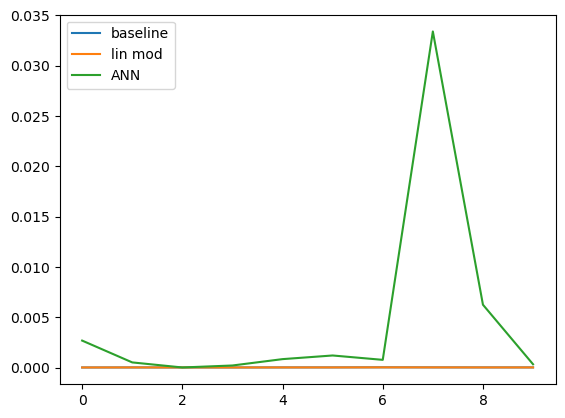

In [13]:
plot(error_test_baseline)
plot(error_test_lin_mod)
plot(ANN_outer_MSE_list)
legend(['baseline', 'lin mod','ANN'])


In [21]:
mean_error_of_inner_h

array([1.14675571e-05, 3.19630073e-04, 2.61147044e-03, 6.80870293e-03,
       8.96252560e-03, 2.07059008e-02, 1.03249770e-02, 5.54155321e-03,
       1.35639203e-02, 1.11557788e-02])